# Analiza i predikcija kratkoročnih logaritamskih prinosa S&P 500 indeksa primenom modela vremenskih serija

**Autor:** Miloš Trišić RA39/2023  
**Predmet:** Numerički algoritmi i numerički softver (NANS)  

---

## 0. Uvod i opis problema

**S&P 500** (Standard & Poor's 500) je berzanski indeks koji prati kretanje 500 najvećih američkih kompanija po tržišnoj kapitalizaciji. Ovaj indeks je kapitalizacijski ponderisan, što znači da kompanije poput Apple-a, Microsoft-a i NVIDIA-e imaju veći uticaj na njegovo kretanje od manjih kompanija. Zbog toga ga mnogi ekonomisti smatraju najboljim pokazateljem stanja američke ekonomije u celini.

Cilj ovog projekta je ispitati u kojoj meri savremeni modeli vremenskih serija mogu da se primene za analizu i kratkoročnu predikciju kretanja ovog indeksa (tačnije njegovih logaritamskih prinosa "log-returns" - objašnjeno u nastavku). Konkretno:

- Analiza i identifikacija osnovnih karakteristika serije (trend, sezonalnost, cikličnost, šum)
- Predikcija pomoću **ARIMA** i **Facebook Prophet** modela
- Modelovanje volatilnosti pomoću **GARCH** modela
- Deskriptivna **PCA** analiza kompanija i sektora koji najviše doprinose varijansi tržišta

### Zbog čega je modelovanje ovakvih pojava problematično?

Finansijska tržišta su po prirodi veoma kompleksna – na vrednost indeksa istovremeno utiče veliki broj faktora (makroekonomski pokazatelji, geopolitika, raspoloženje investitora, izveštaji kompanija, kao i mnogobrojni nepredvidivi faktori...). Zbog toga ćemo videti da modeli vremenskih serija imaju ograničene performanse u smislu tačne predikcije vrednosti, ali nam i dalje daju korisne uvide o **strukturi serije** i **dinamici volatilnosti**.

### Horizont predikcije

Predikciju vršimo za **1 trading dan unapred**, koristeći walk-forward evaluaciju na test skupu. Razlog za ovako kratak horizont je propagacija greške – što dalje predviđamo, interval neizvesnosti eksponencijalno raste, pa su predikcije duže od 2-3 dana za finansijske serije uglavnom nepouzdane.

---
## 1. Učitavanje podataka i pretprocesiranje

Pre nego što krenemo na analizu i modelovanje, učitavamo podatke, sređujemo ih i delimo na skupove za trening, validaciju i testiranje.

### Podela podataka

Kod vremenskih serija podela mora biti **strogo hronološka** – ne možemo koristiti  random-split kao kod klasičnih ML problema. Ako bi podaci iz budućnosti ušli u trening skup, model bi imao informacije koje u realnosti ne bi imao u trenutku predikcije (*data leakage*). Dakle, koristimo sledeću podelu:

| Skup | Period | Napomena |
|------|--------|----------|
| **Train** | 2014-12-23 → 2022-12-30 | Uključuje COVID krizu (2020) i tržišni pad (2022) |
| **Validation** | 2023-01-03 → 2023-12-29 | Za određivanje parametara modela |
| **Test** | 2024-01-02 → 2024-12-20 | Finalna evaluacija – ne koristimo dok ne dobijemo finalne verzije modela spremne za testiranje |

Validacioni skup koristimo tokom razvoja za odabir parametara (npr. p, d, q za ARIMA). Test skup koristimo **samo jednom**, na kraju, za finalno poređenje karakteristika dobijenih modela.

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, '.')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 11
sns.set_theme(style='whitegrid')

print('Biblioteke uspešno učitane.')

Biblioteke uspešno učitane.


In [2]:
from src.preprocessing import load_and_prepare, print_split_info

train, val, test, companies = load_and_prepare(
    index_path     = 'data/sp500_index.csv',
    companies_path = 'data/sp500_companies.csv'
)

print_split_info(train, val, test)

       Train: 2014-12-23 → 2022-12-30 | 2020 trading dana (80.3%)
  Validation: 2023-01-03 → 2023-12-29 |  250 trading dana (9.9%)
        Test: 2024-01-02 → 2024-12-20 |  246 trading dana (9.8%)
      Ukupno: 2516 trading dana


### Pregled učitanih tabela

Koristimo tabele :
- `sp500_index.csv` – dnevne zatvarajuće vrednosti indeksa za svaki trading dan (vikendi i praznici su prirodno odsutni)
- `sp500_companies.csv` – metapodaci o kompanijama: sektor, industrija, tržišna kapitalizacija, ponder u indeksu itd. Ova tabela koristiće nam u PCA analizi.

In [3]:
print('=== Prvih 5 redova (train) ===')
display(train.head())

print('\n=== Poslednjih 5 redova (train) ===')
display(train.tail())

print('\n=== Prvih 5 redova (test) ===')
display(test.head())

=== Prvih 5 redova (train) ===


,S&P500,log_return
Date,,
2014-12-23,2082.17,0.001745
2014-12-24,2081.88,-0.000139
2014-12-26,2088.77,0.003304
2014-12-29,2090.57,0.000861
2014-12-30,2080.35,-0.004901



=== Poslednjih 5 redova (train) ===


,S&P500,log_return
Date,,
2022-12-23,3844.82,0.005851
2022-12-27,3829.25,-0.004058
2022-12-28,3783.22,-0.012093
2022-12-29,3849.28,0.017311
2022-12-30,3839.50,-0.002544



=== Prvih 5 redova (test) ===


,S&P500,log_return
Date,,
2024-01-02,4742.83,-0.005677
2024-01-03,4704.81,-0.008049
2024-01-04,4688.68,-0.003434
2024-01-05,4697.24,0.001824
2024-01-08,4763.54,0.014016


In [4]:
cols = ['Symbol', 'Shortname', 'Sector', 'Marketcap', 'Weight']
print(f'Broj kompanija: {len(companies)}')
print(f'Broj sektora:   {companies["Sector"].nunique()}')
print()
display(companies[cols].head(10))

Broj kompanija: 502
Broj sektora:   11



,Symbol,Shortname,Sector,Marketcap,Weight
0,AAPL,Apple Inc.,Technology,3846819807232,0.069209
1,NVDA,NVIDIA Corporation,Technology,3298803056640,0.059350
2,MSFT,Microsoft Corporation,Technology,3246068596736,0.058401
3,AMZN,"Amazon.com, Inc.",Consumer Cyclical,2365033807872,0.042550
4,GOOGL,Alphabet Inc.,Communication Services,2351625142272,0.042309
5,GOOG,Alphabet Inc.,Communication Services,2351623045120,0.042309
6,META,"Meta Platforms, Inc.",Communication Services,1477457739776,0.026581
7,TSLA,"Tesla, Inc.",Consumer Cyclical,1351627833344,0.024317
8,AVGO,Broadcom Inc.,Technology,1031217348608,0.018553
9,BRK-B,Berkshire Hathaway Inc. New,Financial Services,978776031232,0.017609


In [5]:
#Agregacija broja kompanija i ukupne težine (kolona Weights) po sektorima
sektor_count = companies.groupby('Sector').agg(
    Broj_kompanija=('Symbol', 'count'),
    Weight=('Weight', 'sum')
).sort_values('Weight', ascending=False).round(4)

display(sektor_count)

,Broj_kompanija,Weight
Sector,,
Technology,82,0.3110
Communication Services,22,0.1404
Financial Services,67,0.1279
Consumer Cyclical,55,0.1146
Healthcare,62,0.0934
Industrials,70,0.0677
Consumer Defensive,37,0.0585
Energy,22,0.0288
Utilities,32,0.0226


---
## 2. Vizualizacija i eksplorativna analiza podataka (EDA)

### 2.1 Zašto ne modelujemo originalne vrednosti indeksa direktno?

Pre nego što transformišemo podatke, pogledajmo kako izgleda originalna vrednost S&P 500 indeksa kroz ceo posmatrani period. Na osnovu onoga što vidimo, donećemo zaključke o tome šta zapravo treba da modelujemo.

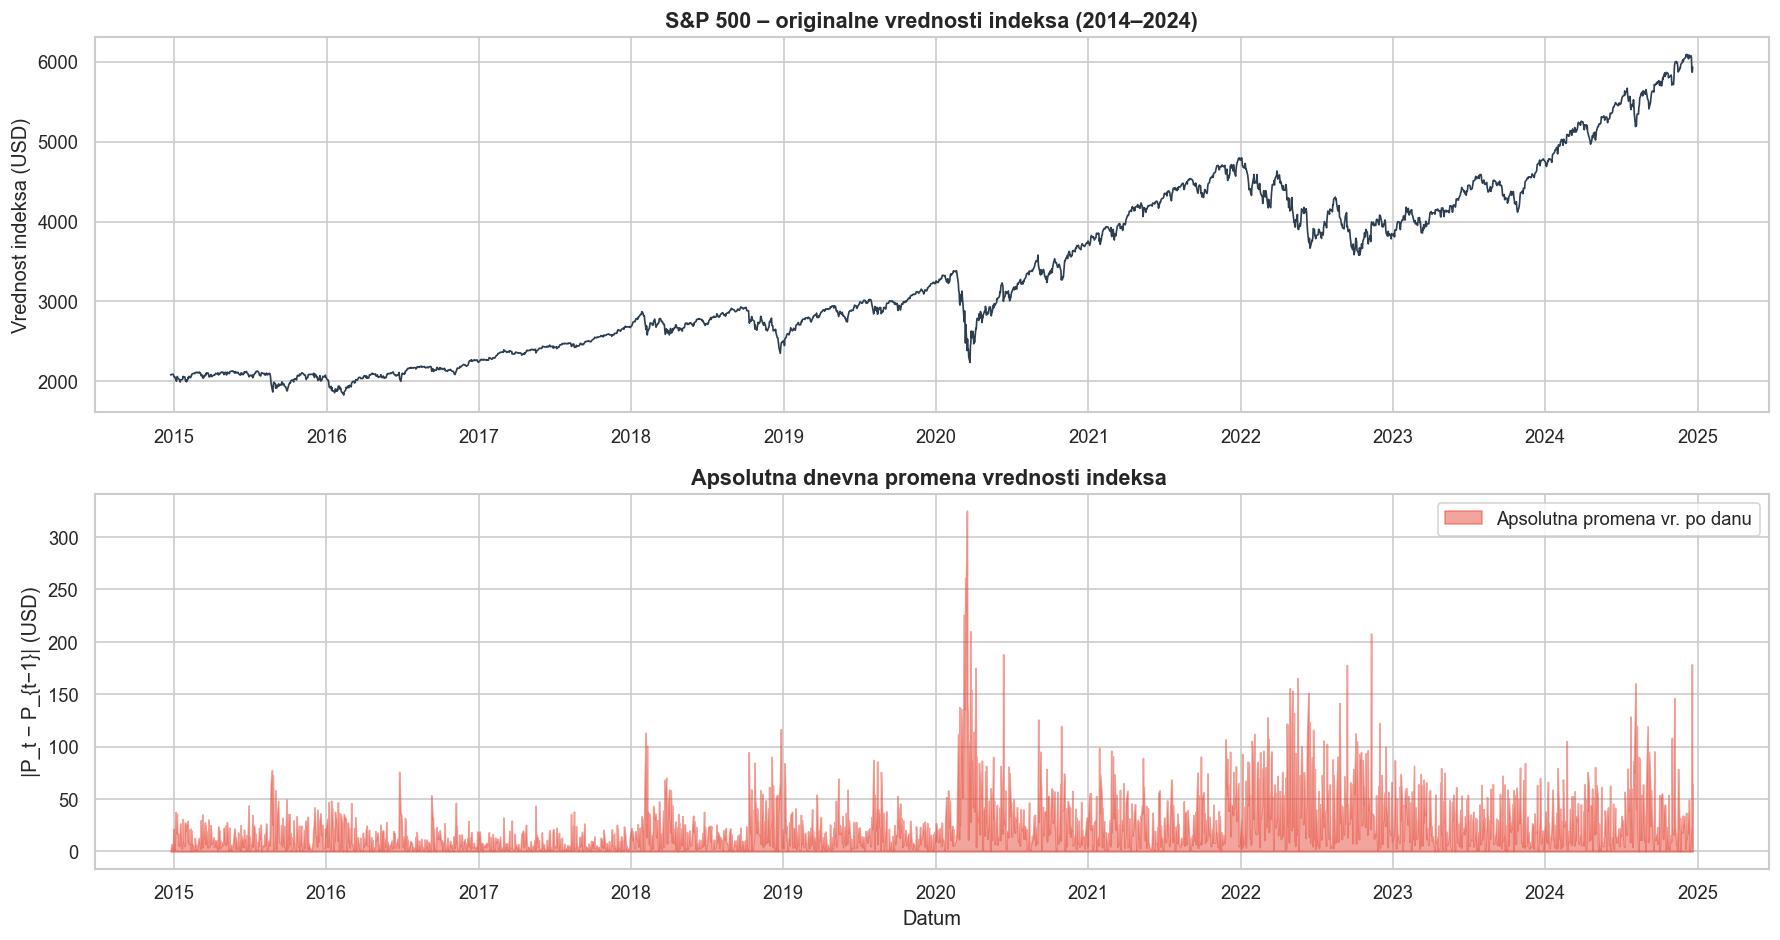

In [6]:
full_df = pd.concat([train, val, test])

fig, axes = plt.subplots(2, 1, figsize=(15, 8))

# ── Gornji grafik: originalne vrednosti ─────────────────────────────────────────
axes[0].plot(full_df.index, full_df['S&P500'], color='#2c3e50', linewidth=1.0)
axes[0].set_title('S&P 500 – originalne vrednosti indeksa (2014–2024)',
                   fontsize=13, fontweight='bold')
axes[0].set_ylabel('Vrednost indeksa (USD)')

# ── Donji grafik: apsolutna dnevna promena ─────────────────────────────
abs_changes = full_df['S&P500'].diff().abs()
axes[1].fill_between(full_df.index, abs_changes,
                     color='#e74c3c', alpha=0.5, label='Apsolutna promena vr. po danu')
axes[1].set_title('Apsolutna dnevna promena vrednosti indeksa ',
                   fontsize=13, fontweight='bold')
axes[1].set_ylabel('|P_t − P_{t−1}| (USD)')
axes[1].set_xlabel('Datum')
axes[1].legend()

for ax in axes:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

Sa grafika možemo uočiti dva problema koja direktnu primenu modela na vrednost indeksa čine problematičnom :

1. **Jasan rastući trend** – indeks je porastao sa ~2000 na ~6000 USD tokom posmatranog perioda. Serija nema konstantnu srednju vrednost, što znači da **nije stacionarna**. Stacionarnost je osnovna pretpostavka ARIMA i srodnih modela, pa direktna primena na originalnu vrednost indeksa nije moguća.

2. **Varijansa raste sa trendom** – apsolutne dnevne promene su neuporedivo veće u 2024. nego 2015. Ovo ukazuje na **multiplikativni karakter** serije.

Oba problema rešavamo jednom transformacijom – prelaskom na logaritamske prinose.

### 2.2 Prelaz na logaritamske prinose (log-returns)

Umesto cena, modelujem **logaritamske dnevne prinose**:

$$r_t = \ln\left(\frac{P_t}{P_{t-1}}\right) = \ln(P_t) - \ln(P_{t-1})$$

Ova transformacija direktno rešava oba problema uočena na prethodnom grafiku:

- **Uklanja trend** – log-returns su centrirani oko nule. 

- **Stabilizuje varijansu** – logaritmovanje pretvara multiplikativni model u aditivni: log(T · S · C · R) = log(T) + log(S) + log(C) + log(R), čime se oscilacije normalizuju.
- **Aditivnost** – višednevni prinos dobijamo prostim sabiranjem dnevnih log-returns, što olakšava interpretaciju.

Pogledajmo kako serija izgleda nakon transformacije.

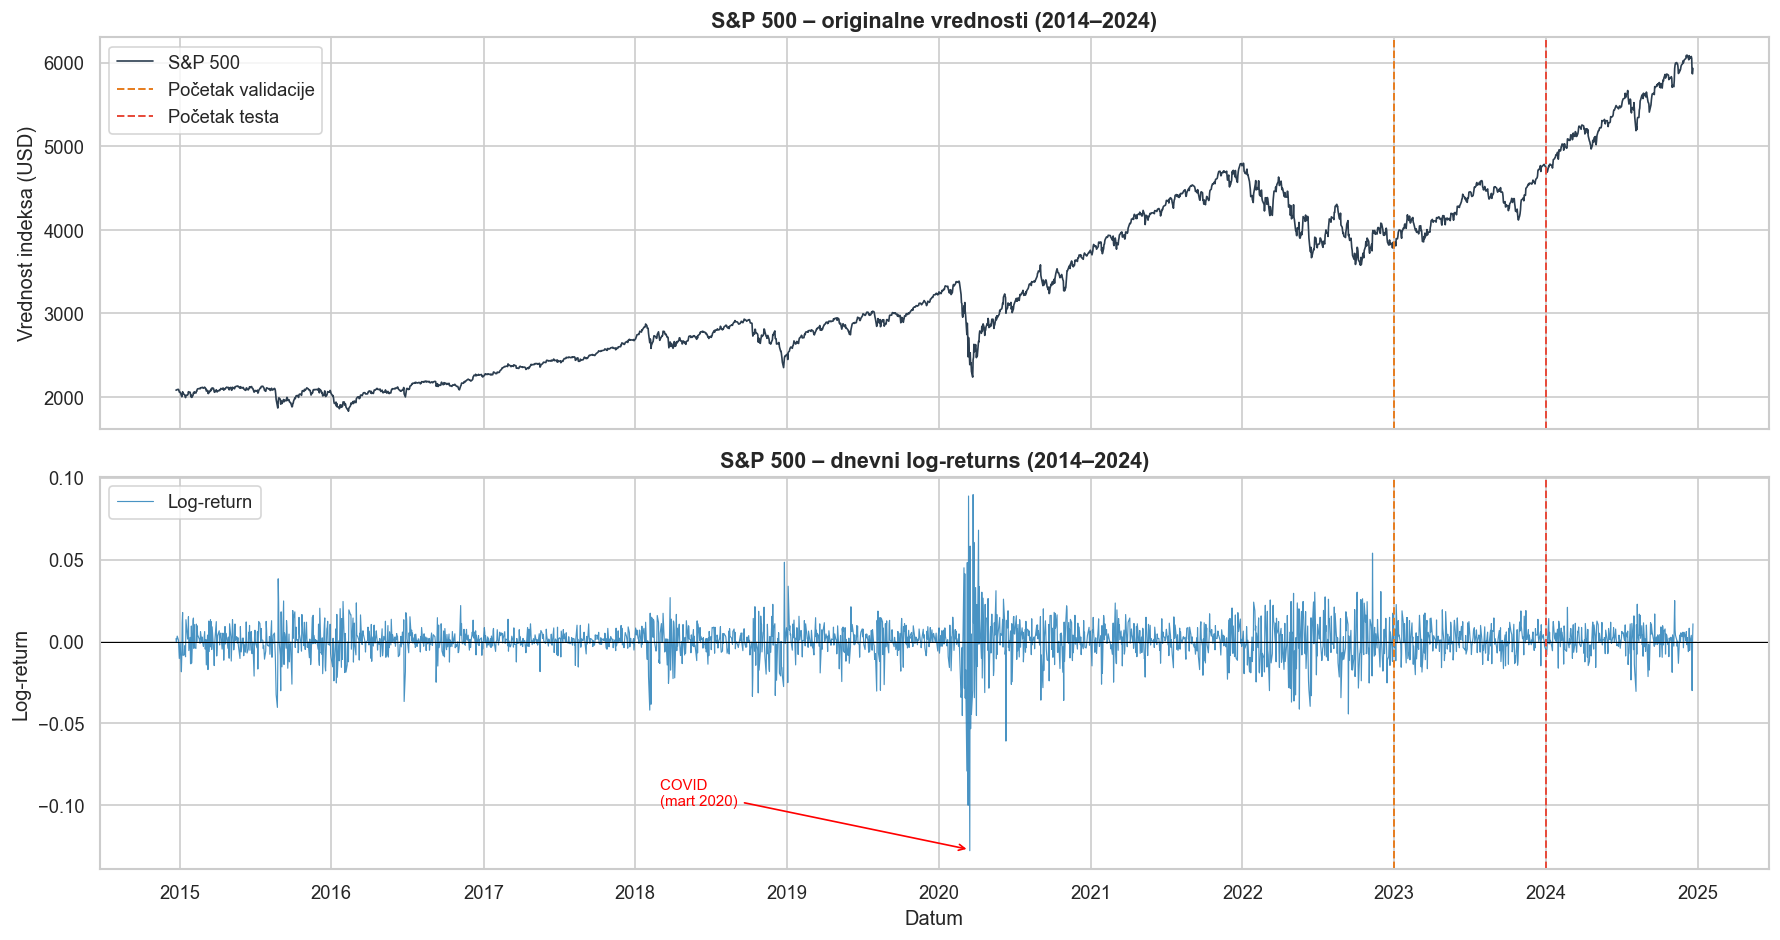

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# ── Gornji: cene sa oznakom skupova ──────────────────────────────────
axes[0].plot(full_df.index, full_df['S&P500'],
             color='#2c3e50', linewidth=1.0, label='S&P 500')
axes[0].axvline(pd.Timestamp('2023-01-01'), color='#e67e22',
                linestyle='--', linewidth=1.2, label='Početak validacije')
axes[0].axvline(pd.Timestamp('2024-01-01'), color='#e74c3c',
                linestyle='--', linewidth=1.2, label='Početak testa')
axes[0].set_ylabel('Vrednost indeksa (USD)')
axes[0].set_title('S&P 500 – originalne vrednosti (2014–2024)', fontsize=13, fontweight='bold')
axes[0].legend(loc='upper left')

# ── Donji: log-returns ────────────────────────────────────────────────
axes[1].plot(full_df.index, full_df['log_return'],
             color='#2980b9', linewidth=0.7, alpha=0.85, label='Log-return')
axes[1].axhline(0, color='black', linewidth=0.6)
axes[1].axvline(pd.Timestamp('2023-01-01'), color='#e67e22',
                linestyle='--', linewidth=1.2)
axes[1].axvline(pd.Timestamp('2024-01-01'), color='#e74c3c',
                linestyle='--', linewidth=1.2)
axes[1].annotate('COVID \n(mart 2020)',
                 xy=(pd.Timestamp('2020-03-16'), -0.127),
                 xytext=(pd.Timestamp('2018-03-01'), -0.10),
                 arrowprops=dict(arrowstyle='->', color='red'),
                 fontsize=9, color='red')
axes[1].set_ylabel('Log-return')
axes[1].set_xlabel('Datum')
axes[1].set_title('S&P 500 – dnevni log-returns (2014–2024)', fontsize=13, fontweight='bold')
axes[1].legend(loc='upper left')

axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[1].xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()
plt.show()

Log-returns serija već vizualno deluje stacionarno – osciluje oko nule bez vidljivog trenda, a širina oscilacija je grubim pogledom relativno stabilna. Međutim, mogu se primetiti periodi gde su oscilacije znatno veće (COVID mart 2020, kao i pad tokom 2022.) – pojava poznata kao **volatility clustering** i jedna od ključnih motivacija za primenu GARCH modela. Formalnu potvrdu stacionarnosti ostavljam za sekciju 3.

<div style="display: flex; align-items: flex-start; gap: 40px;">

<div style="flex: 1;">

### 2.3 Deskriptivna statistika

Pogledajmo osnovne statističke karakteristike log-returns za svaki skup. Posebno nas interesuju **skewness** (asimetričnost) i **kurtosis** (zaobljenost) jer finansijske serije tipično pokazuju pozitivnu kurtozu – češće pojavljivanje ekstremnih vrednosti u odnosu na normalnu raspodelu.

</div>

<div style="flex: 1;">

<img src="resources/skewness_kurtosis.png" style="width: 370px;" >

</div>

</div>

In [8]:
from scipy import stats as scipy_stats

def describe_extended(series: pd.Series, naziv: str) -> pd.Series:
    desc = series.describe()
    desc['skewness'] = series.skew()
    desc['kurtosis'] = series.kurtosis()  # excess kurtosis (0 = normalna raspodela)
    return desc.rename(naziv)

stat_df = pd.concat([
    describe_extended(train['log_return'], 'Train'),
    describe_extended(val['log_return'],   'Validation'),
    describe_extended(test['log_return'],  'Test'),
], axis=1).round(6)

display(stat_df)

,Train,Validation,Test
count,2020.000000,250.000000,246.000000
mean,0.000304,0.000868,0.000886
std,0.011911,0.008241,0.007962
min,-0.127652,-0.020245,-0.030427
25%,-0.003853,-0.004188,-0.002900
50%,0.000556,0.000835,0.001053
75%,0.005696,0.006274,0.005623
max,0.089683,0.022584,0.024981
skewness,-0.817348,-0.030574,-0.580125
kurtosis,15.500699,-0.186887,1.971569


### 2.4 Distribucija log-returns i test normalnosti

Poredimo posmatranu distribuciju sa normalnom raspodelom. Ako kurtoza bude značajno pozitivna (što se očekuje) – to znači da su ekstremni dani (veliki padovi ili skokovi) češći nego što bi normalna raspodela predviđala. Ovo je jedan od argumenata u korist GARCH modela koji može da modeluje periode povećane neizvesnosti.

Koristićemo **Jarque-Bera test** za formalnu proveru normalnosti.

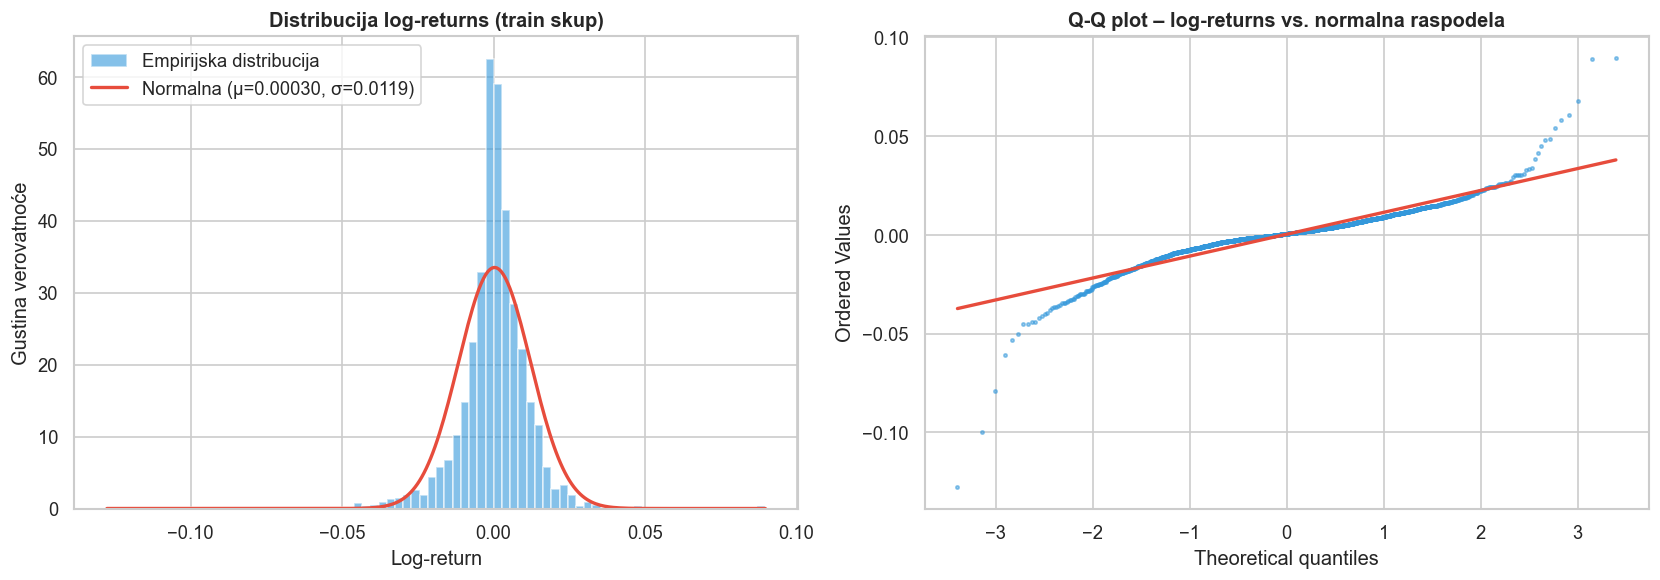

Jarque-Bera test normalnosti:
  JB statistika = 20339.80
  p-vrednost    = 0.00e+00
  Zaključak: distribucija log-returns NIJE normalna (α = 0.05)


In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

lr = train['log_return']
mu, sigma = lr.mean(), lr.std()

# ── Levo: histogram + normalna kriva ─────────────────────────────────
axes[0].hist(lr, bins=80, density=True,
             color='#3498db', alpha=0.6, label='Empirijska distribucija')
x = np.linspace(lr.min(), lr.max(), 300)
axes[0].plot(x, scipy_stats.norm.pdf(x, mu, sigma),
             color='#e74c3c', linewidth=2,
             label=f'Normalna (μ={mu:.5f}, σ={sigma:.4f})')
axes[0].set_title('Distribucija log-returns (train skup)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Log-return')
axes[0].set_ylabel('Gustina verovatnoće')
axes[0].legend()

# ── Desno: Q-Q plot ───────────────────────────────────────────────────
scipy_stats.probplot(lr, dist='norm', plot=axes[1])
axes[1].set_title('Q-Q plot – log-returns vs. normalna raspodela', fontsize=12, fontweight='bold')
axes[1].get_lines()[0].set(color='#3498db', markersize=2, alpha=0.5)
axes[1].get_lines()[1].set(color='#e74c3c', linewidth=2)

plt.tight_layout()
plt.show()

jb_stat, jb_p = scipy_stats.jarque_bera(lr)
print(f'Jarque-Bera test normalnosti:')
print(f'  JB statistika = {jb_stat:.2f}')
print(f'  p-vrednost    = {jb_p:.2e}')
print(f'  Zaključak: distribucija log-returns {"NIJE" if jb_p < 0.05 else "jeste"} normalna (α = 0.05)')

**Interpretacija:** Na histogramu se vidi da je vrh empirijske distribucije viši i uži od normalne krive, a Q-Q plot jasno pokazuje odstupanje na oba repa – tačke skaču iznad linije za pozitivne ekstreme i ispod nje za negativne. Jarque-Bera test formalno potvrđuje da distribucija log-returns nije normalna. Ova osobina – **leptokurtičnost** – tipična je za finansijske serije i znači da modeli koji pretpostavljaju normalnost mogu da potcene verovatnoću ekstremnih događaja koji su kod ovakvih serija prisutni.

### 2.5 Pokretna srednja vrednost i volatilnost

Da bismo bolje videli dinamiku serije, računamo **pokretnu standardnu devijaciju** na prozoru od 30 trading dana. Ovo je jednostavna empirijska mera volatilnosti – pokazuje koliko su oscilacije bile velike u svakom 30-dnevnom periodu, bez ikakvog modela.

Ako volatilnost nije ravnomerno raspoređena kroz vreme već se grupiše u specifičnim periodima, radi se o **volatility clustering**-u – i upravo to GARCH modeluje.

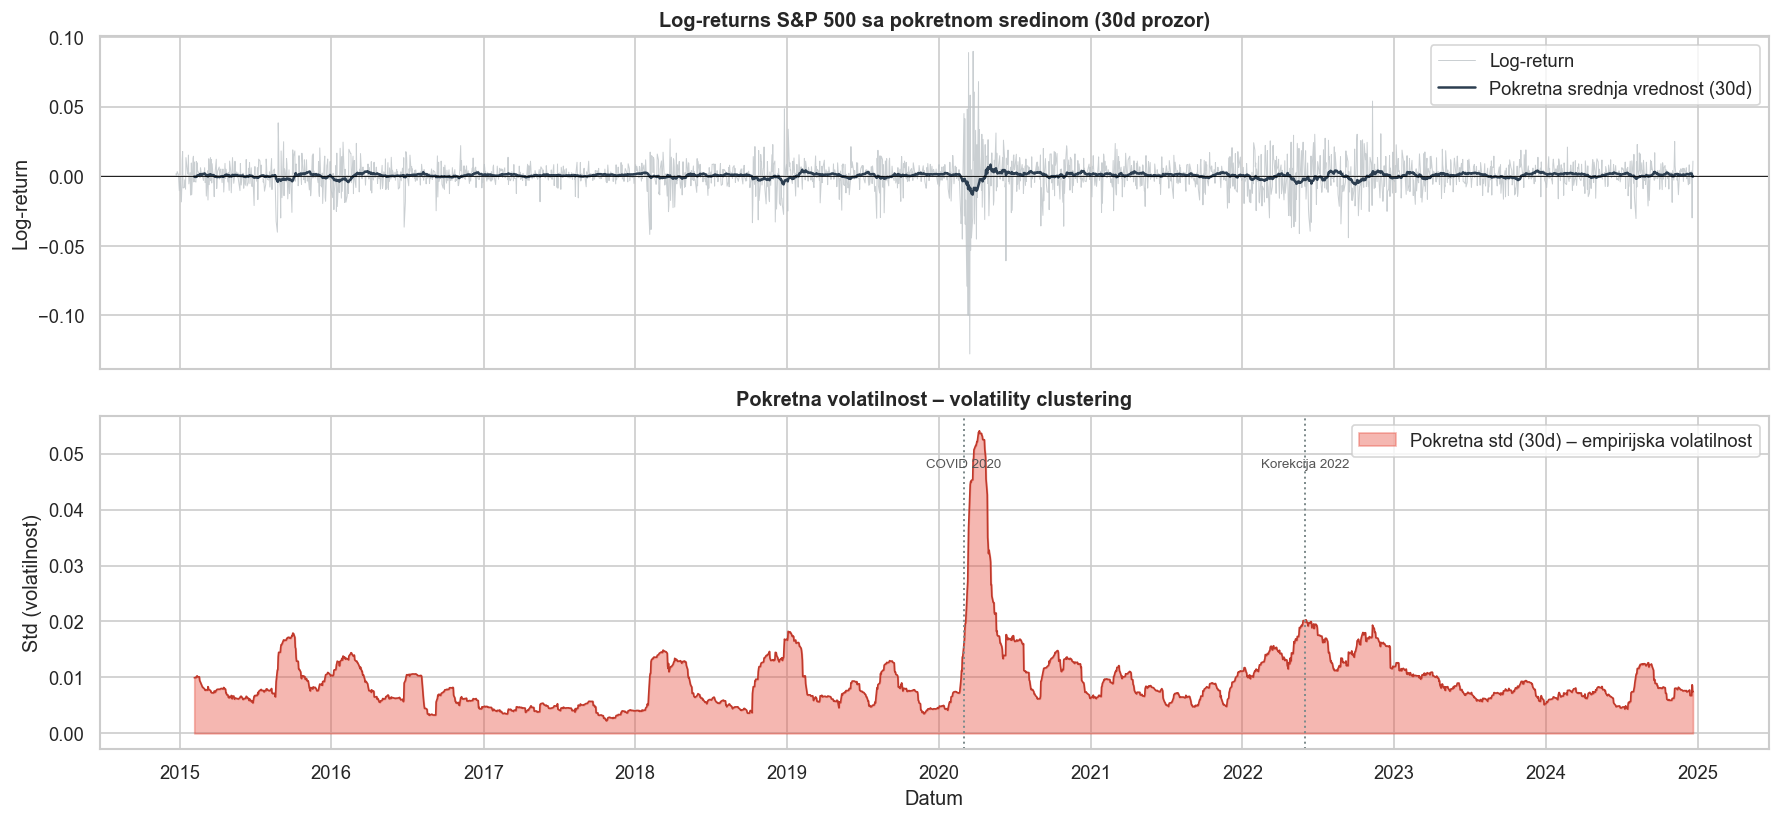

In [10]:
window = 30  # širina posmatranog prozora k=30

rolling_mean = full_df['log_return'].rolling(window).mean()
rolling_std  = full_df['log_return'].rolling(window).std()

fig, axes = plt.subplots(2, 1, figsize=(15, 7), sharex=True)

# ── Gornji: log-returns + pokretna sredina ────────────────────────────
axes[0].plot(full_df.index, full_df['log_return'],
             color='#bdc3c7', linewidth=0.6, alpha=0.8, label='Log-return')
axes[0].plot(rolling_mean.index, rolling_mean,
             color='#2c3e50', linewidth=1.5,
             label=f'Pokretna srednja vrednost ({window}d)')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].set_ylabel('Log-return')
axes[0].set_title(f'Log-returns S&P 500 sa pokretnom sredinom ({window}d prozor)',
                   fontsize=12, fontweight='bold')
axes[0].legend()

# ── Donji: pokretna volatilnost ───────────────────────────────────────
axes[1].fill_between(rolling_std.index, rolling_std,
                     color='#e74c3c', alpha=0.4,
                     label=f'Pokretna std ({window}d) – empirijska volatilnost')
axes[1].plot(rolling_std.index, rolling_std, color='#c0392b', linewidth=1.0)

for datum, tekst in [
    ('2020-03-01', 'COVID 2020'),
    ('2022-06-01', 'Korekcija 2022'),
]:
    axes[1].axvline(pd.Timestamp(datum), color='#7f8c8d', linestyle=':', linewidth=1.2)
    axes[1].text(pd.Timestamp(datum), rolling_std.max() * 0.88,
                 tekst, fontsize=8, ha='center', color='#555')

axes[1].set_ylabel('Std (volatilnost)')
axes[1].set_xlabel('Datum')
axes[1].set_title('Pokretna volatilnost – volatility clustering',
                   fontsize=12, fontweight='bold')
axes[1].legend()

axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[1].xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()
plt.show()

**Interpretacija:** Volatilnost nije konstantna – za vreme COVID krize i tokom 2022. standardna devijacija je višestruko veća nego u mirnim periodima. Vidljivo je i da se visoka volatilnost ne smiruje odmah, već traje neko vreme pre nego što se vrati na niske vrednosti, što takođe opravdava primenu GARCH modela.

### 2.6 STL dekompozicija

Primenjujem **STL dekompoziciju** (Seasonal-Trend decomposition using LOESS) da bih formalno razdvojio seriju na komponente: trend, sezonalnost i reziduale.

Za period sezonalnosti uzimam **252 trading dana** što odgovara jednoj berzanskoj godini. Pošto su log-returns već transformisana serija, očekujem da trend i sezonalnost budu mali u poređenju sa rezidualnim šumom – što bi potvrdilo da je serija dominantno nepredvidiva i da je predikcija tačne vrednosti log-returns prilično nepouzdana i teška.

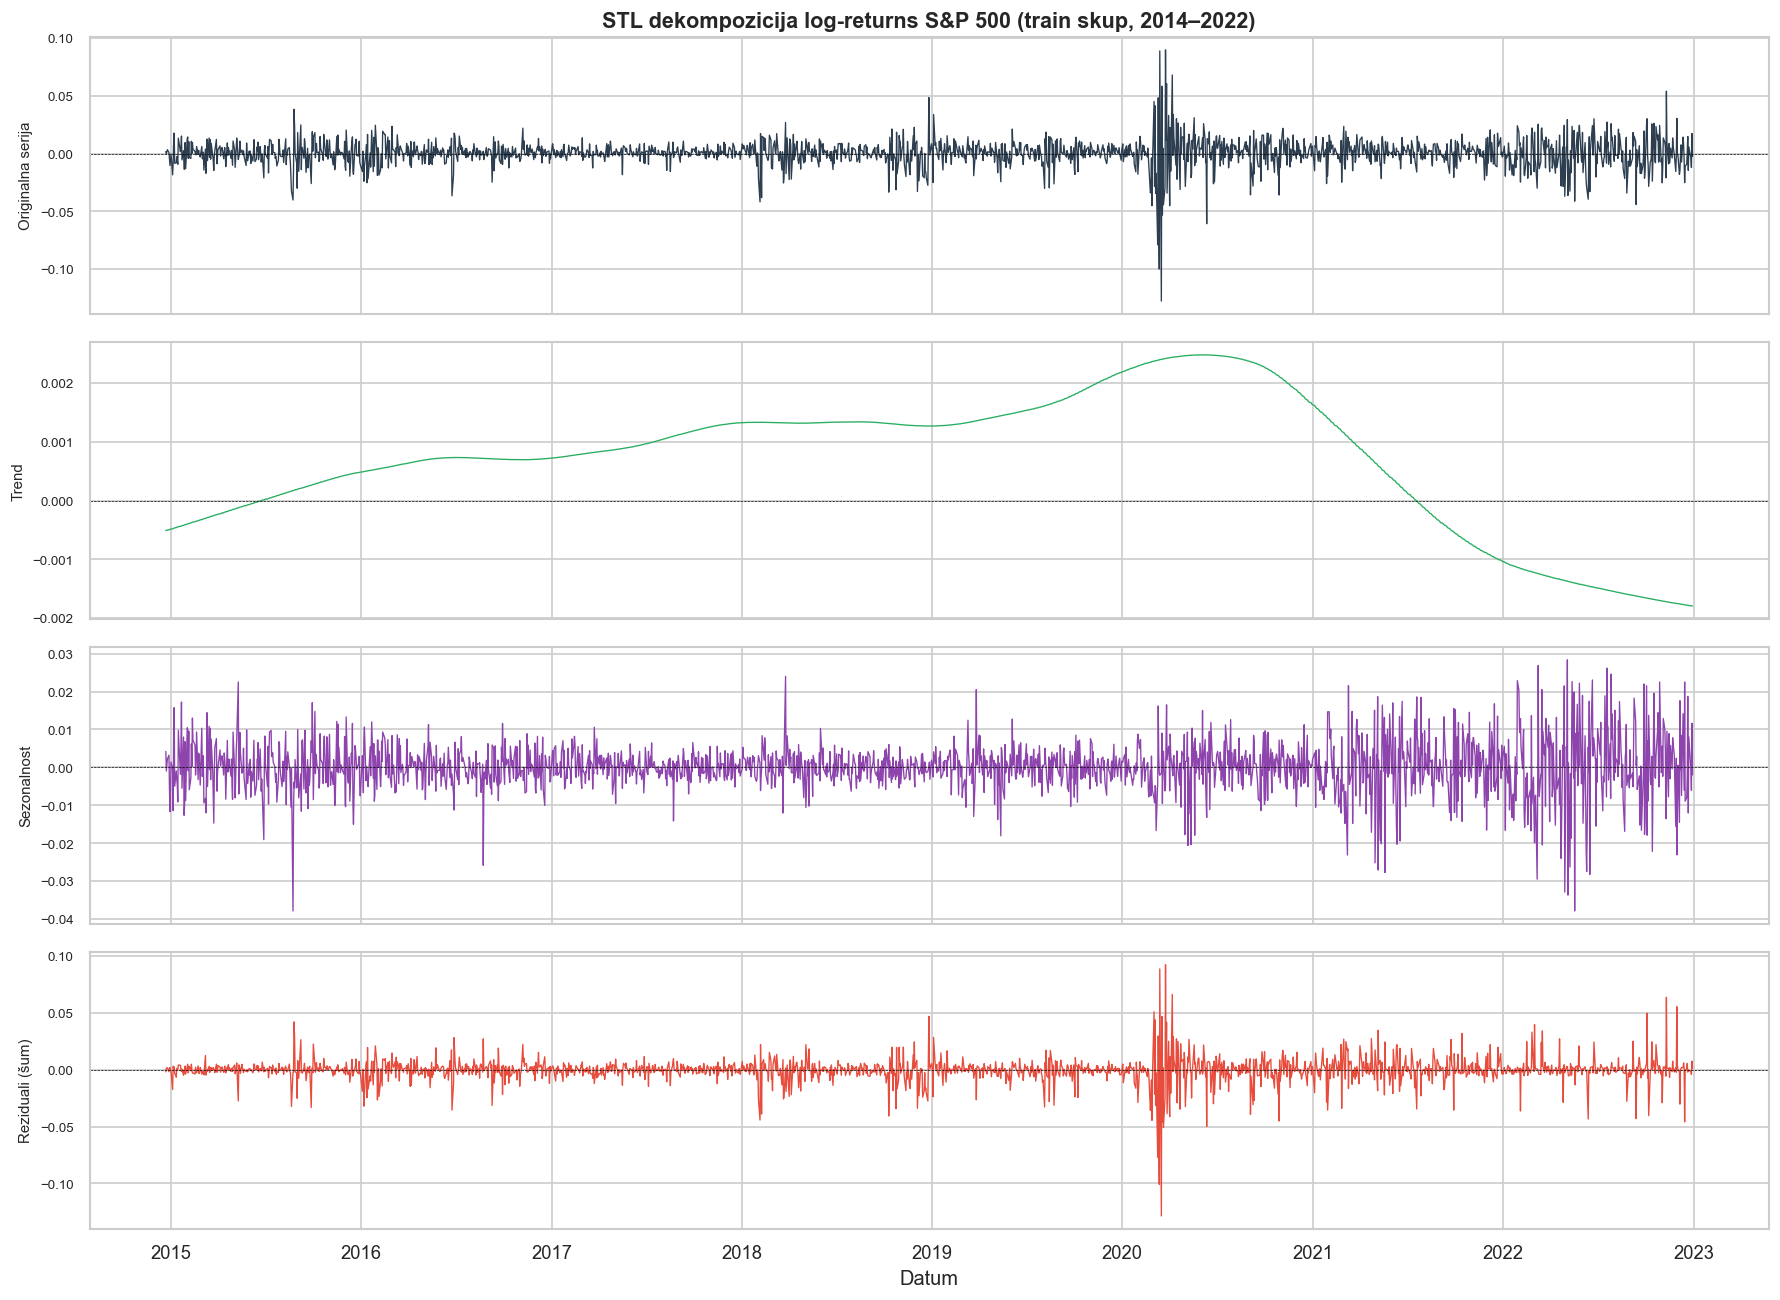

=== Udeo varijanse po komponentama ===
  Trend          : 0.90%
  Sezonalnost    : 31.65%
  Reziduali      : 84.34%


In [11]:
from statsmodels.tsa.seasonal import STL

stl = STL(train['log_return'], period=252, robust=True)
result = stl.fit()

fig, axes = plt.subplots(4, 1, figsize=(15, 11), sharex=True)

komponente = [
    (train['log_return'], 'Originalna serija', '#2c3e50'),
    (result.trend,        'Trend',             '#27ae60'),
    (result.seasonal,     'Sezonalnost',       '#8e44ad'),
    (result.resid,        'Reziduali (šum)',   '#e74c3c'),
]

for ax, (data, naziv, boja) in zip(axes, komponente):
    ax.plot(data.index, data.values, color=boja, linewidth=0.8)
    ax.axhline(0, color='black', linewidth=0.4, linestyle='--')
    ax.set_ylabel(naziv, fontsize=9)
    ax.tick_params(axis='y', labelsize=8)

axes[0].set_title('STL dekompozicija log-returns S&P 500 (train skup, 2014–2022)',
                   fontsize=13, fontweight='bold')
axes[-1].set_xlabel('Datum')
axes[-1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axes[-1].xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout()
plt.show()

var_total = train['log_return'].var()
print('=== Udeo varijanse po komponentama ===')
for naziv, vrednost in [
    ('Trend',       result.trend.var()),
    ('Sezonalnost', result.seasonal.var()),
    ('Reziduali',   result.resid.var()),
]:
    print(f'  {naziv:<15}: {100 * vrednost / var_total:.2f}%')

**Interpretacija:** Ako reziduali čine više od 90-95% ukupne varijanse (što je tipično za log-returns finansijskih indeksa), trend i sezonalnost su minimalni – serija je u suštini dominantno šum. Ovo je konzistentno sa hipotezom o efikasnom tržištu i potvrđuje da modeli poput ARIMA ne mogu da daju visoku tačnost predikcije vrednosti.

Ipak, to ne znači da modelovanje nema smisla. ARIMA i Prophet koristim da ispitam da li postoji autokorelaciona struktura u seriji, dok GARCH modeluje **dinamiku volatilnosti**.

---
## 3. Testiranje stacionarnosti

Na osnovu vizualne analize iz prethodne sekcije, log-returns deluju stacionarno – nema vidljivog trenda ni promena u širini oscilacija (izuzev kriznih perioda). Međutim, pre primene bilo kog modela ovo mora biti **formalno potvrđeno** statističkim testom.

Za testiranje stacionarnosti koristim **ADF test** (Augmented Dickey-Fuller). Nulta hipoteza ovog testa je da serija **nije stacionarna**. Ako je p-vrednost ≤ 0.05, odbacujemo nultu hipotezu i zaključujemo da je serija stacionarna sa 95% pouzdanosti.

Testiram obe verzije serije – originalne vrednosti S&P 500 i log-returns

In [12]:
from src.stationarity import adf_test, print_adf_result, compare_adf, plot_acf_pacf, suggest_arima_params

### 3.1 ADF test – originalne vrednosti indeksa (sirove cene)

Prvo testiramo nad sirovim cenama. Pošto smo videli jasan rastući trend, očekujemo da serija neće biti stacionarna – ADF test bi trebalo to da potvrdi.

In [13]:
adf_cene = adf_test(train['S&P500'], naziv='S&P 500 – sirove cene (train)')
print_adf_result(adf_cene)

──────────────────────────────────────────────────
  ADF test: S&P 500 – sirove cene (train)
──────────────────────────────────────────────────
  ADF statistika   : -0.97
  p-vrednost       : 0.764064
  Broj lagova      : 10
  Broj opservacija : 2009
  Kritične vrednosti:
    1%  : -3.4336
    5%  : -2.863
    10% : -2.5675
  Zaključak: NIJE STACIONARNA
──────────────────────────────────────────────────



**Interpretacija:** Sirove cene **nisu stacionarne** – p-vrednost je daleko iznad 0.05, a ADF statistika nije dovoljno negativna da bi prešla kritičnu vrednost. Ovo znači da statistički karakter serije (srednja vrednost, varijansa) nije konstantan kroz vreme, što onemogućava direktnu primenu AR/MA/ARIMA modela.

### 3.2 ADF test – log-returns

Sada testiram log-returns. Ovo je serija sa kojom zapravo radim, i potrebno je da prođe ADF test pre nego što priđem modelovanju.

In [14]:
adf_returns = adf_test(train['log_return'], naziv='S&P 500 – log-returns (train)')
print_adf_result(adf_returns)

──────────────────────────────────────────────────
  ADF test: S&P 500 – log-returns (train)
──────────────────────────────────────────────────
  ADF statistika   : -14.0562
  p-vrednost       : 0.0
  Broj lagova      : 9
  Broj opservacija : 2010
  Kritične vrednosti:
    1%  : -3.4336
    5%  : -2.863
    10% : -2.5675
  Zaključak: STACIONARNA (99%)
──────────────────────────────────────────────────



**Interpretacija:** Log-returns su **stacionarni** – p-vrednost je znatno ispod 0.05, a ADF statistika je negativnija od kritične vrednosti na nivou 1%. Ovo formalno potvrđuje ono što smo videli vizuelno i odobrava primenu ARIMA modela.

---
### 3.3 ACF i PACF analiza

Pošto smo potvrdili stacionarnost, sledeći korak je analiza **autokorelacione strukture** serije. Koristimo dva grafika:

**ACF (autokorelogram)** prikazuje korelaciju serije sa samom sobom pomerenom za k koraka unazad. Ako je vrednost za lag k izvan osenčenog pojasa, ta korelacija je statistički značajna. Obrazac koji tražimo:
- Nagli pad posle q lagova → indikator za MA(q) komponentu
- Postepen pad → indikator za AR komponentu

**PACF (parcijalni autokorelogram)** prikazuje samo **direktan** uticaj prošle vrednosti na sadašnju, eliminišući posredne uticaje. Na primer, ako januar utiče na februar, a februar na mart, PACF za mart neće prikazivati uticaj januara kao značajan (jer je on posredan, ide kroz februar). Obrazac koji tražimo:
- Nagli pad posle p lagova → indikator za AR(p) komponentu
- Postepen pad → indikator za MA komponentu

Osenčen pojas na oba grafika predstavlja vrednosti koje bismo sa 95% verovatnoće dobili za čisti šum (white noise). Sve vrednosti van tog pojasa su statistički značajne.

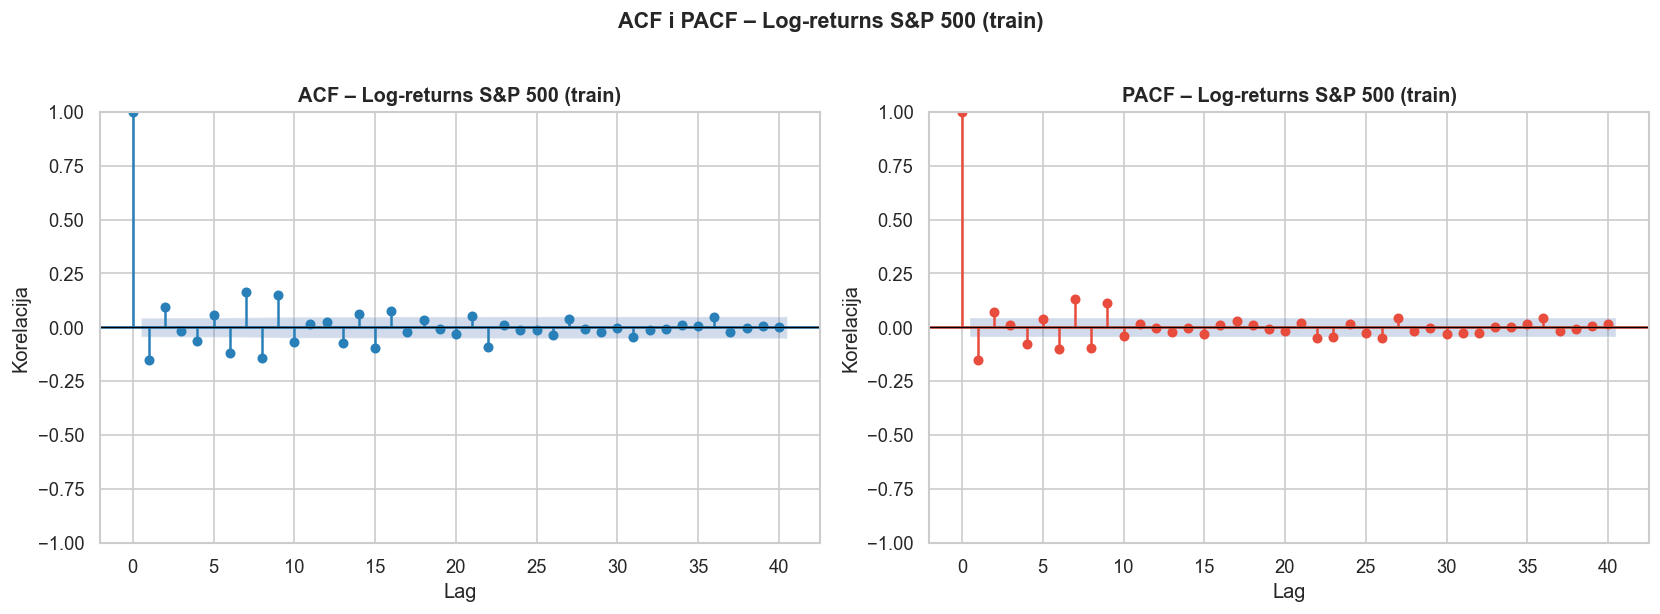

In [15]:
plot_acf_pacf(
    series = train['log_return'],
    lags   = 40,
    naziv  = 'Log-returns S&P 500 (train)'
)

**Interpretacija ACF i PACF grafika:**

Log-returns S&P 500 pokazuju slab ili gotovo nepostojeći autokorelacioni signal – većina vrednosti se nalazi unutar osenčenog pojasa. Ovo je konzistentno sa hipotezom o efikasnom tržištu: ako bi postojala jaka i predvidiva autokorelaciona struktura, investitori bi je iskoristili i ona bi nestala.

Nekoliko napomena za interpretaciju rezultata koje vidimo:
- Ako su gotovo sve vrednosti ACF i PACF unutar granica → serija je bliska belom šumu, parametri p i q biće mali (0 ili 1)
- Ako postoje izolovani značajni lagovi → uzimamo poslednji značajni lag kao polaznu tačku za p ili q
- Konačnu odluku o parametrima donosimo kombinovanjem ove ručne analize sa auto_arima analizom

### 3.4 Okvirna preporuka parametara na osnovu ACF/PACF

In [16]:
preporuka = suggest_arima_params(train['log_return'], lags=40)

print('=== Okvirna preporuka parametara (ACF/PACF heuristika) ===')
print(f"  p (AR red) : {preporuka['p']}")
print(f"  d (dif red) : {preporuka['d']}")
print(f"  q (MA red) : {preporuka['q']}")
print(f"  Napomena   : {preporuka['napomena']}")

=== Okvirna preporuka parametara (ACF/PACF heuristika) ===
  p (AR red) : 27
  d (dif red) : 0
  q (MA red) : 36
  Napomena   : Heuristika – koristiti zajedno sa auto_arima i AIC/BIC.


---
### Zaključak sekcije 3

- ADF test formalno je potvrdio da su **sirove cene nestacionarne**, a **log-returns stacionarni** – parametar d u ARIMA modelu biće 0
- ACF i PACF analiza dala je okvirne vrednosti za parametre p i q
- Ovu ručnu procenu koristimo kao polaznu tačku, a pomoću auto_arima vršimo sistematičnu pretragu kombinacija parametara i biramo optimalnu na osnovu AIC kriterijuma

**Sledeći korak:** Parametri ARIMA modela (`src/arima_model.py`)

---
## 4. ARIMA model

**ARIMA (AutoRegressive Integrated Moving Average)** kombinuje tri komponente:

- **AR(p)** – autoregresivna komponenta: trenutna vrednost je linearna kombinacija prethodnih p vrednosti serije
- **I(d)** – diferenciranje reda d: koliko puta diferenciramo seriju da bi postala stacionarna
- **MA(q)** – komponenta pokretnog proseka grešaka: trenutna vrednost zavisi od prethodnih q grešaka modela

Pošto smo u sekciji 3 potvrdili da su log-returns već stacionarni, parametar **d=0** i efektivno radimo sa ARMA(p,q) modelom.

### Važna napomena o očekivanjima

Log-returns S&P 500 su po prirodi bliske belom šumu – ACF i PACF u sekciji 3 pokazali su slab autokorelacioni signal. Zbog toga ARIMA neće dati niske greške u apsolutnom smislu, i to **nije greška modela** – to je priroda finansijskih serija. Cilj ARIMA modela je :
1. Formalno ispitati postoji li i kakva predvidiva struktura u seriji
2. Generisati rezidualne greške koje prosleđujemo GARCH modelu za modelovanje volatilnosti

In [17]:
from src.arima_model import (
    auto_arima_search,
    fit_arima,
    walk_forward_predict,
    dijagnostika_reziduala,
    plot_arima_predictions,
    plot_arima_residuals,
    get_reziduali_za_garch,
)
from src.evaluation import compute_all_metrics

### 4.1 Pretraga optimalnih parametara – auto_arima

Koristim `auto_arima` iz biblioteke `pmdarima` da sistematično pretražim kombinacije parametara (p, d, q) i odaberem onu sa najnižim **AIC** (Akaike Information Criterion).

**AIC** meri balans između tačnosti modela i njegove kompleksnosti – kompleksniji model (više parametara) se kažnjava. Niži AIC = bolji model. Koristim AIC umesto BIC jer AIC favorizuje malo kompleksnije modele što je za predikciju obično bolje.

In [18]:
auto_result = auto_arima_search(
    series  = train['log_return'],
    max_p   = 5,
    max_q   = 5,
    max_d   = 1,
    ic      = 'aic',
    verbose = True,
)

optimalni_order = auto_result['order']
print(f"\nOdabrani parametri za ARIMA: {optimalni_order}")

Pokrećem auto_arima (kriterijum: AIC, max_p=5, max_q=5)...
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-12163.707, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-12209.751, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-12202.770, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-12218.183, Time=0.28 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-12216.346, Time=0.32 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-12216.023, Time=0.50 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-12212.699, Time=0.25 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-12214.217, Time=0.64 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-12217.742, Time=0.56 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0]          
Total fit time: 2.887 seconds

Optimalni model: ARIMA(2,0,0)
  AIC: -12218.1828
  BIC: -12201.3502

Odabrani parametri za ARIMA: (2, 0, 0)


**Interpretacija:** Poredimo rezultat auto_arima sa ručnom procenom iz sekcije 3. Ako se slažu – to je potvrda da je ručna analiza ACF/PACF bila ispravna. Ako se razlikuju – koristićemo auto_arima parametre jer su dobijeni sistematičnom pretragom.

Za log-returns finansijskih indeksa auto_arima tipično predlaže modele niskog reda – ARIMA(0,0,0), ARIMA(1,0,0) ili ARIMA(0,0,1) – slab autokorelacioni signal koji smo videli na ACF/PACF graficima.

### 4.2 Treniranje modela

Treniramo ARIMA model na trening skupu sa odabranim parametrima.

In [19]:
arima_fitted = fit_arima(
    series = train['log_return'],
    order  = optimalni_order,
)

print(arima_fitted.summary())

Treniram ARIMA(2,0,0) na 2020 opservacija...
  AIC: -12217.7416
  BIC: -12195.2982
                               SARIMAX Results                                
Dep. Variable:             log_return   No. Observations:                 2020
Model:                 ARIMA(2, 0, 0)   Log Likelihood                6112.871
Date:                Thu, 26 Feb 2026   AIC                         -12217.742
Time:                        01:32:02   BIC                         -12195.298
Sample:                             0   HQIC                        -12209.505
                               - 2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.136      0.256      -0.000       0.001
ar.L1         -0.1432      0.009    -15.124     

**Tumačenje:**

- **Koeficijenti (coef)** – vrednosti AR i MA parametara; ako im je p-vrednost (P>|z|) veća od 0.05, taj parametar nije statistički značajan
- **AIC / BIC** – što niži, to bolje; koristiće nam za poređenje sa Prophet modelom
- **Ljung-Box test (Q)** na dnu – ako je p-vrednost > 0.05, reziduali ne pokazuju autokorelaciju što znači da je model dobro uhvatio strukturu serije

### 4.3 Walk-forward validacija na validacionom skupu

Pre nego što pokrenemo evaluaciju na test skupu, testiram model na **validacionom skupu** (2023. godina).

Walk-forward validacija simulira realnu upotrebu: svaki dan predviđam vrednost za sledeći dan, a zatim pravu vrednost unosim u istoriju pre sledeće predikcije.

In [20]:
# Validaciona evaluacija
arima_val_rezultati = walk_forward_predict(
    train = train['log_return'],
    test  = val['log_return'],
    order = optimalni_order,
)

# Metrike na validacionom skupu
arima_val_metrike = compute_all_metrics(
    y_true     = arima_val_rezultati['y_true'].values,
    y_pred     = arima_val_rezultati['y_pred'].values,
    y_train    = train['log_return'].values,
    model_name = f'ARIMA{optimalni_order} – Validation'
)

display(arima_val_metrike)

Walk-forward validacija – ARIMA(2,0,0), 250 predikcija
  50/250 predikcija završeno...
  100/250 predikcija završeno...
  150/250 predikcija završeno...
  200/250 predikcija završeno...
  250/250 predikcija završeno...
  Walk-forward validacija završena.


,Model,MAE,RMSE,MASE
0,"ARIMA(2, 0, 0) – Validation",0.00668,0.008397,0.5948


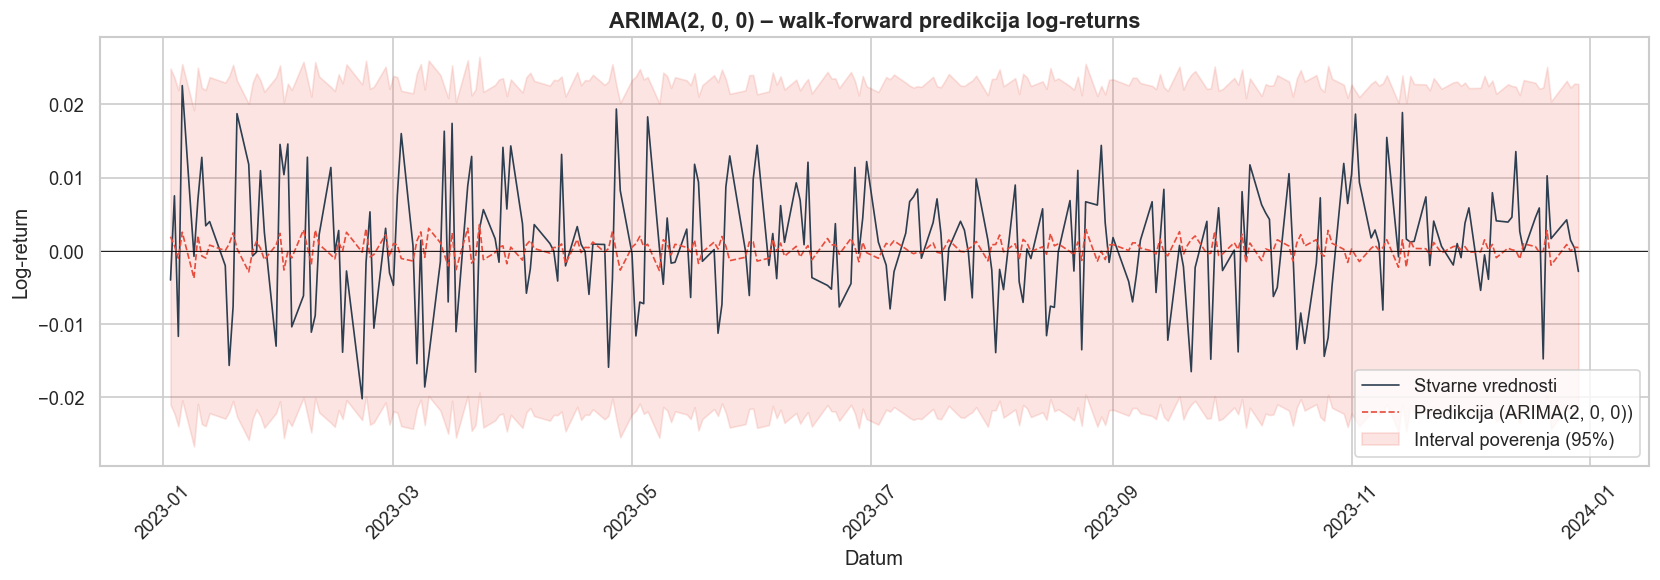

In [21]:
plot_arima_predictions(
    rezultati  = arima_val_rezultati,
    model_name = f'ARIMA{optimalni_order}',
)

### 4.4 Finalna evaluacija na test skupu

Sada pokrećem evaluaciju na **test skupu** (2024. godina). Ovo radimo samo jednom – rezultate koristimo za finalnu komparaciju modela.

In [22]:
# Proširujem trening skup sa validacionim pre finalne evaluacije
train_full = pd.concat([train['log_return'], val['log_return']])

arima_test_rezultati = walk_forward_predict(
    train = train_full,
    test  = test['log_return'],
    order = optimalni_order,
)

arima_test_metrike = compute_all_metrics(
    y_true     = arima_test_rezultati['y_true'].values,
    y_pred     = arima_test_rezultati['y_pred'].values,
    y_train    = train_full.values,
    model_name = f'ARIMA{optimalni_order} – Test'
)

display(arima_test_metrike)

Walk-forward validacija – ARIMA(2,0,0), 246 predikcija
  50/246 predikcija završeno...
  100/246 predikcija završeno...
  150/246 predikcija završeno...
  200/246 predikcija završeno...
  Walk-forward validacija završena.


,Model,MAE,RMSE,MASE
0,"ARIMA(2, 0, 0) – Test",0.005942,0.008096,0.5401


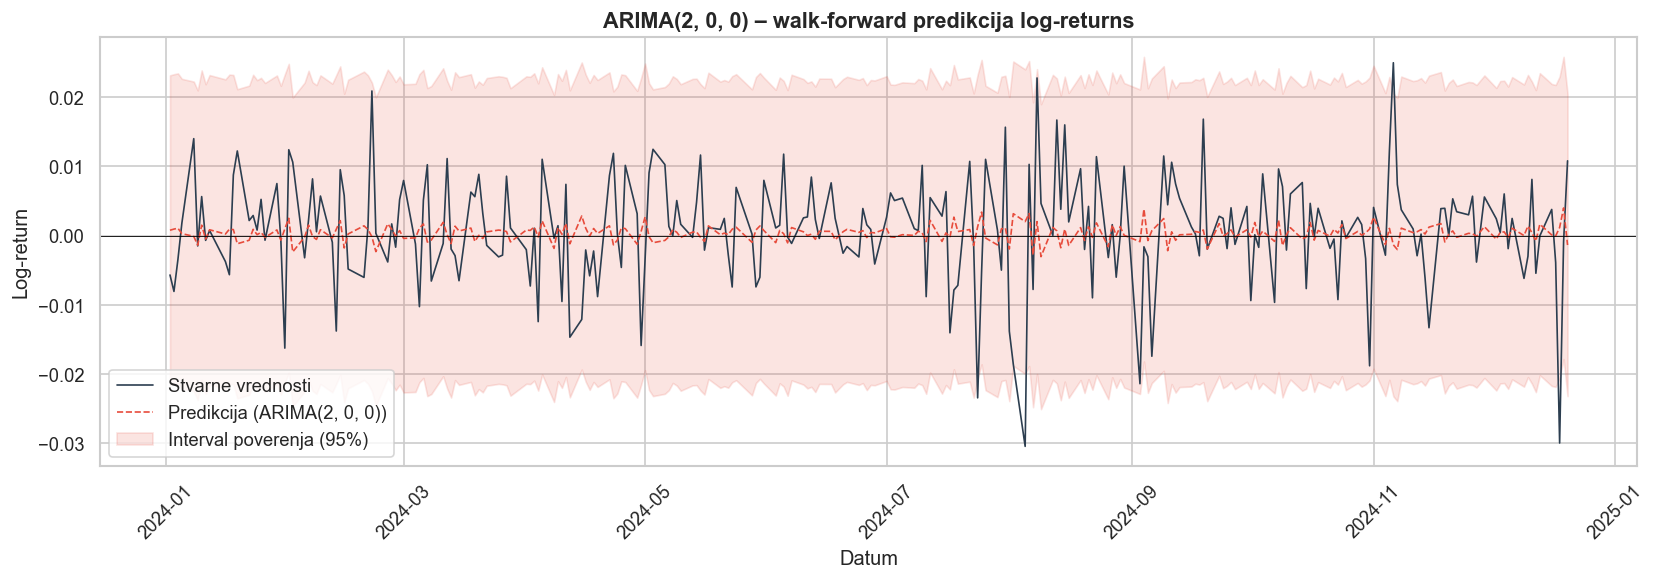

In [23]:
plot_arima_predictions(
    rezultati  = arima_test_rezultati,
    model_name = f'ARIMA{optimalni_order}',
)

### 4.5 Dijagnostika reziduala i priprema za GARCH

Analiziramo rezidualne greške ARIMA modela iz dva razloga:

1. **Provera kvaliteta modela** – ako reziduali sadrže autokorelaciju, model nije dobro uhvatio strukturu serije i parametri možda treba da se koriguju
2. **Provera ARCH efekta** – ako **kvadrirani** reziduali pokazuju autokorelaciju, to znači da postoji volatility clustering u greškama modela, što je direktna motivacija za GARCH

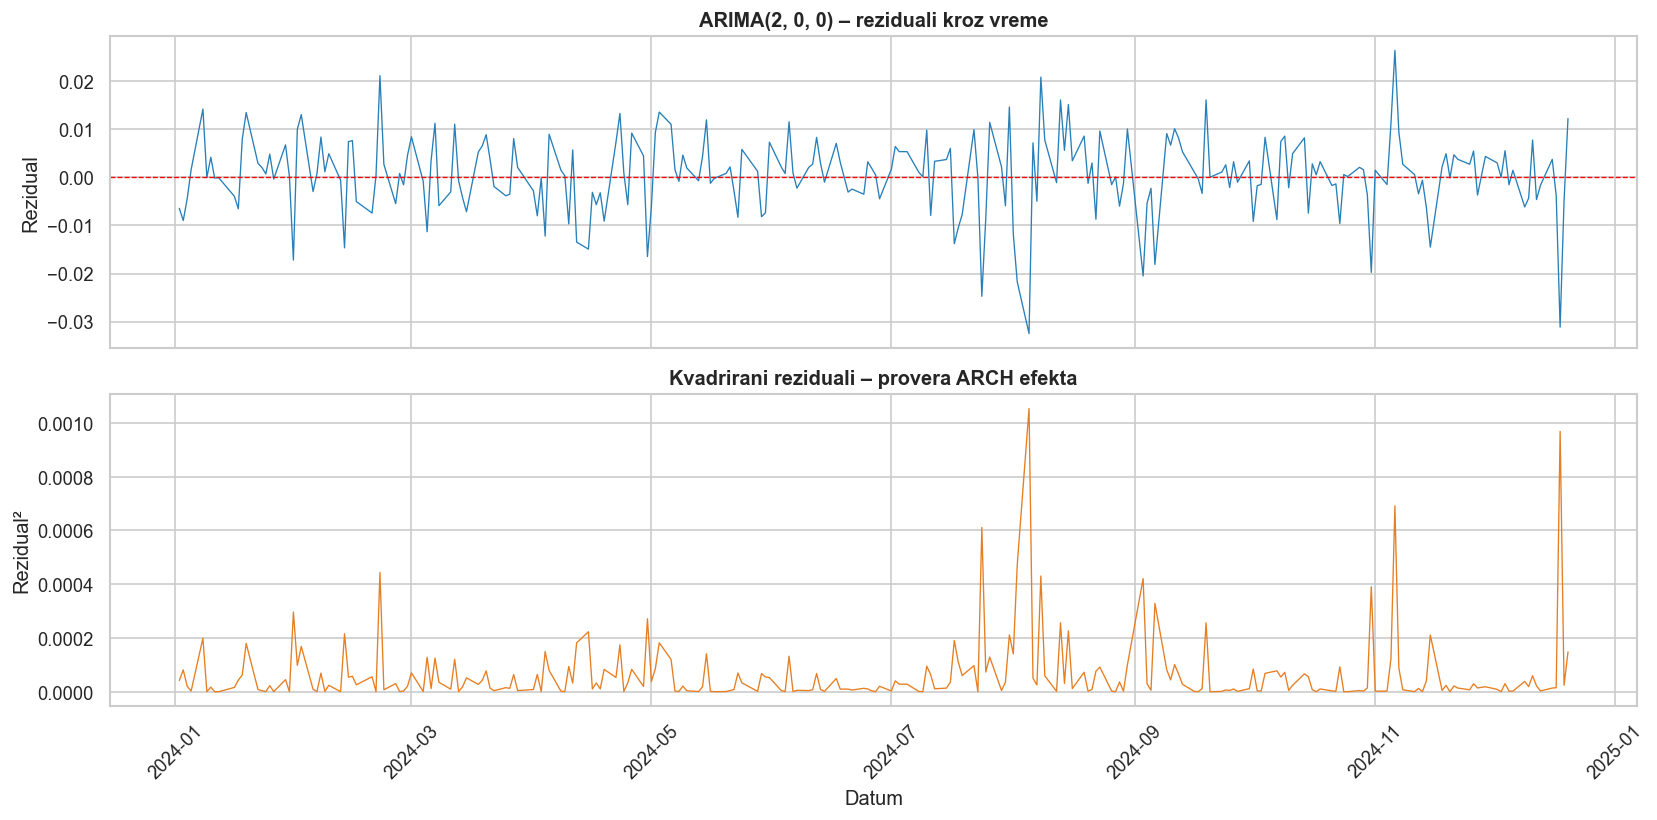

In [24]:
plot_arima_residuals(
    rezultati  = arima_test_rezultati,
    model_name = f'ARIMA{optimalni_order}',
)

In [25]:
dijagnostika = dijagnostika_reziduala(
    rezultati  = arima_test_rezultati,
    model_name = f'ARIMA{optimalni_order}',
)

# Čuvamo reziduale za GARCH
arima_reziduali = get_reziduali_za_garch(arima_test_rezultati)
print(f"Reziduali za GARCH: {len(arima_reziduali)} opservacija, "
      f"period {arima_reziduali.index[0].date()} → {arima_reziduali.index[-1].date()}")

───────────────────────────────────────────────────────
  Dijagnostika reziduala – ARIMA(2, 0, 0)
───────────────────────────────────────────────────────

  Ljung-Box (reziduali) – H0: nema autokorelacije
      lb_stat  lb_pvalue
10  12.279618   0.266779
20  24.769598   0.210388

  Ljung-Box (reziduali²) – H0: nema ARCH efekta
      lb_stat  lb_pvalue
10  15.266476   0.122644
20  19.478935   0.490919

  ARCH efekat: NE
───────────────────────────────────────────────────────

Reziduali za GARCH: 246 opservacija, period 2024-01-02 → 2024-12-20


napomena : Dijagnostika na test skupu nije uhvatila ARCH efekat jer je 2024. godina bila relativno stabilna (bull period).

---
### Zaključak sekcije 4

ARIMA model potvrdio je ono što je ACF/PACF analiza nagovestila – log-returns S&P 500
imaju slab autokorelacioni signal i serija je bliska belom šumu. MAE od 0.00594 i RMSE
od 0.0081 su na skali samih log-returns pa ih je teško tumačiti.
Ključna metrika je **MASE** = 0.54 – model je 46% tačniji od naivnog prediktora, što
potvrđuje da AR(2) struktura ipak nosi korisnu informaciju uprkos sličnosti šumu.

Međutim, dijagnostika reziduala otkrila je da su periodi visoke i niske varijanse grupisani su zajedno (volatility
clustering). Ovo je ključan podatak koji opravdava primenu GARCH modela: dok ARIMA
modeluje srednju vrednost serije, GARCH modeluje njenu varijansu (volatilnost).

Rezidualne greške ARIMA modela sačuvane su u promenljivoj `arima_reziduali` i
prosleđuju se direktno GARCH modelu.

**Sledeći korak:** Prophet model (`src/prophet_model.py`)

***#TODO***

**PROPHET**

**GARCH**

**PCA**

**ZAKLJUCAK**